# W9 G4 Identification of Hammerstein-Wiener models


## Content
- What are Hammerstein-Wiener models
- Model intuition example
- Identification process
- Example



## What are Hammerstein-Wiener models


* Input Nonlinearity (f):
  * Static nonlinear transformation of the input signal
  * Examples: saturation, deadzone, polynomial functions
* Linear Dynamic Block (G(q))
  * Captures the system’s internal dynamics
  * Typically modeled using transfer functions, ARX models, or state-space representations
* Output Nonlinearity (h)
  * Static nonlinear transformation of the linear output
  * Examples: quantization, sigmoid, piecewise linear functions

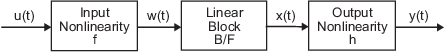


## Some typical formulation
- **Hammerstein-Wiener** model: For systems with nonlinearities at both ends and an linear internal behavior

`Nonlinear Input → Linear Dynamics → Nonlinear Output`

- **Hammerstein** model: For systems where actuators introduce nonlinearities before the dynamics

`Nonlinear Input → Linear Dynamics → Output`

- **Wiener** model: For systems where sensors introduce nonlineraities after the dynamics

`Input → Linear Dynamics → Nonlinear Output`

---

### And the inverted version (not covered)
- **Wiener-Hammerstein** model: For systems with internal nonlinearities between two linear dynamic stages

`Linear dynamics → Nonlinear Block → Linear dynamics`

### Mathematical formulation of **Hammerstein-Wiener** model

`Input → [Nonlinear Block] → [Linear Dynamic Block] → [Nonlinear Block] → Output`

$$
y(t) = h\left(G(q) \cdot f(u(t))\right)
$$

Where:
- $u(t)$: input signal
- $f(\cdot)$: static input nonlinearity
- $G(q)$: linear dynamic operator (e.g., transfer function or state-space model)
- $h(\cdot)$: static output nonlinearity
- $y(t)$: output signal




## Limitations
* Assumes **static** non-linearities
  * Can't capture effect such as hysteresis
* Sensitive to **noise**
  * Noise in input/output data can distort the estimation of nonlinear blocks
* Model structure is **predefined**: selection of nonlinearity types and linear model order
  * Works well if the non-linearities are known from **domain expertise**

## **Example #1**
# **Model intuition: Tesla on Autopilot**



Saving Hammerstein-Wiener Model Tesla case.png to Hammerstein-Wiener Model Tesla case.png


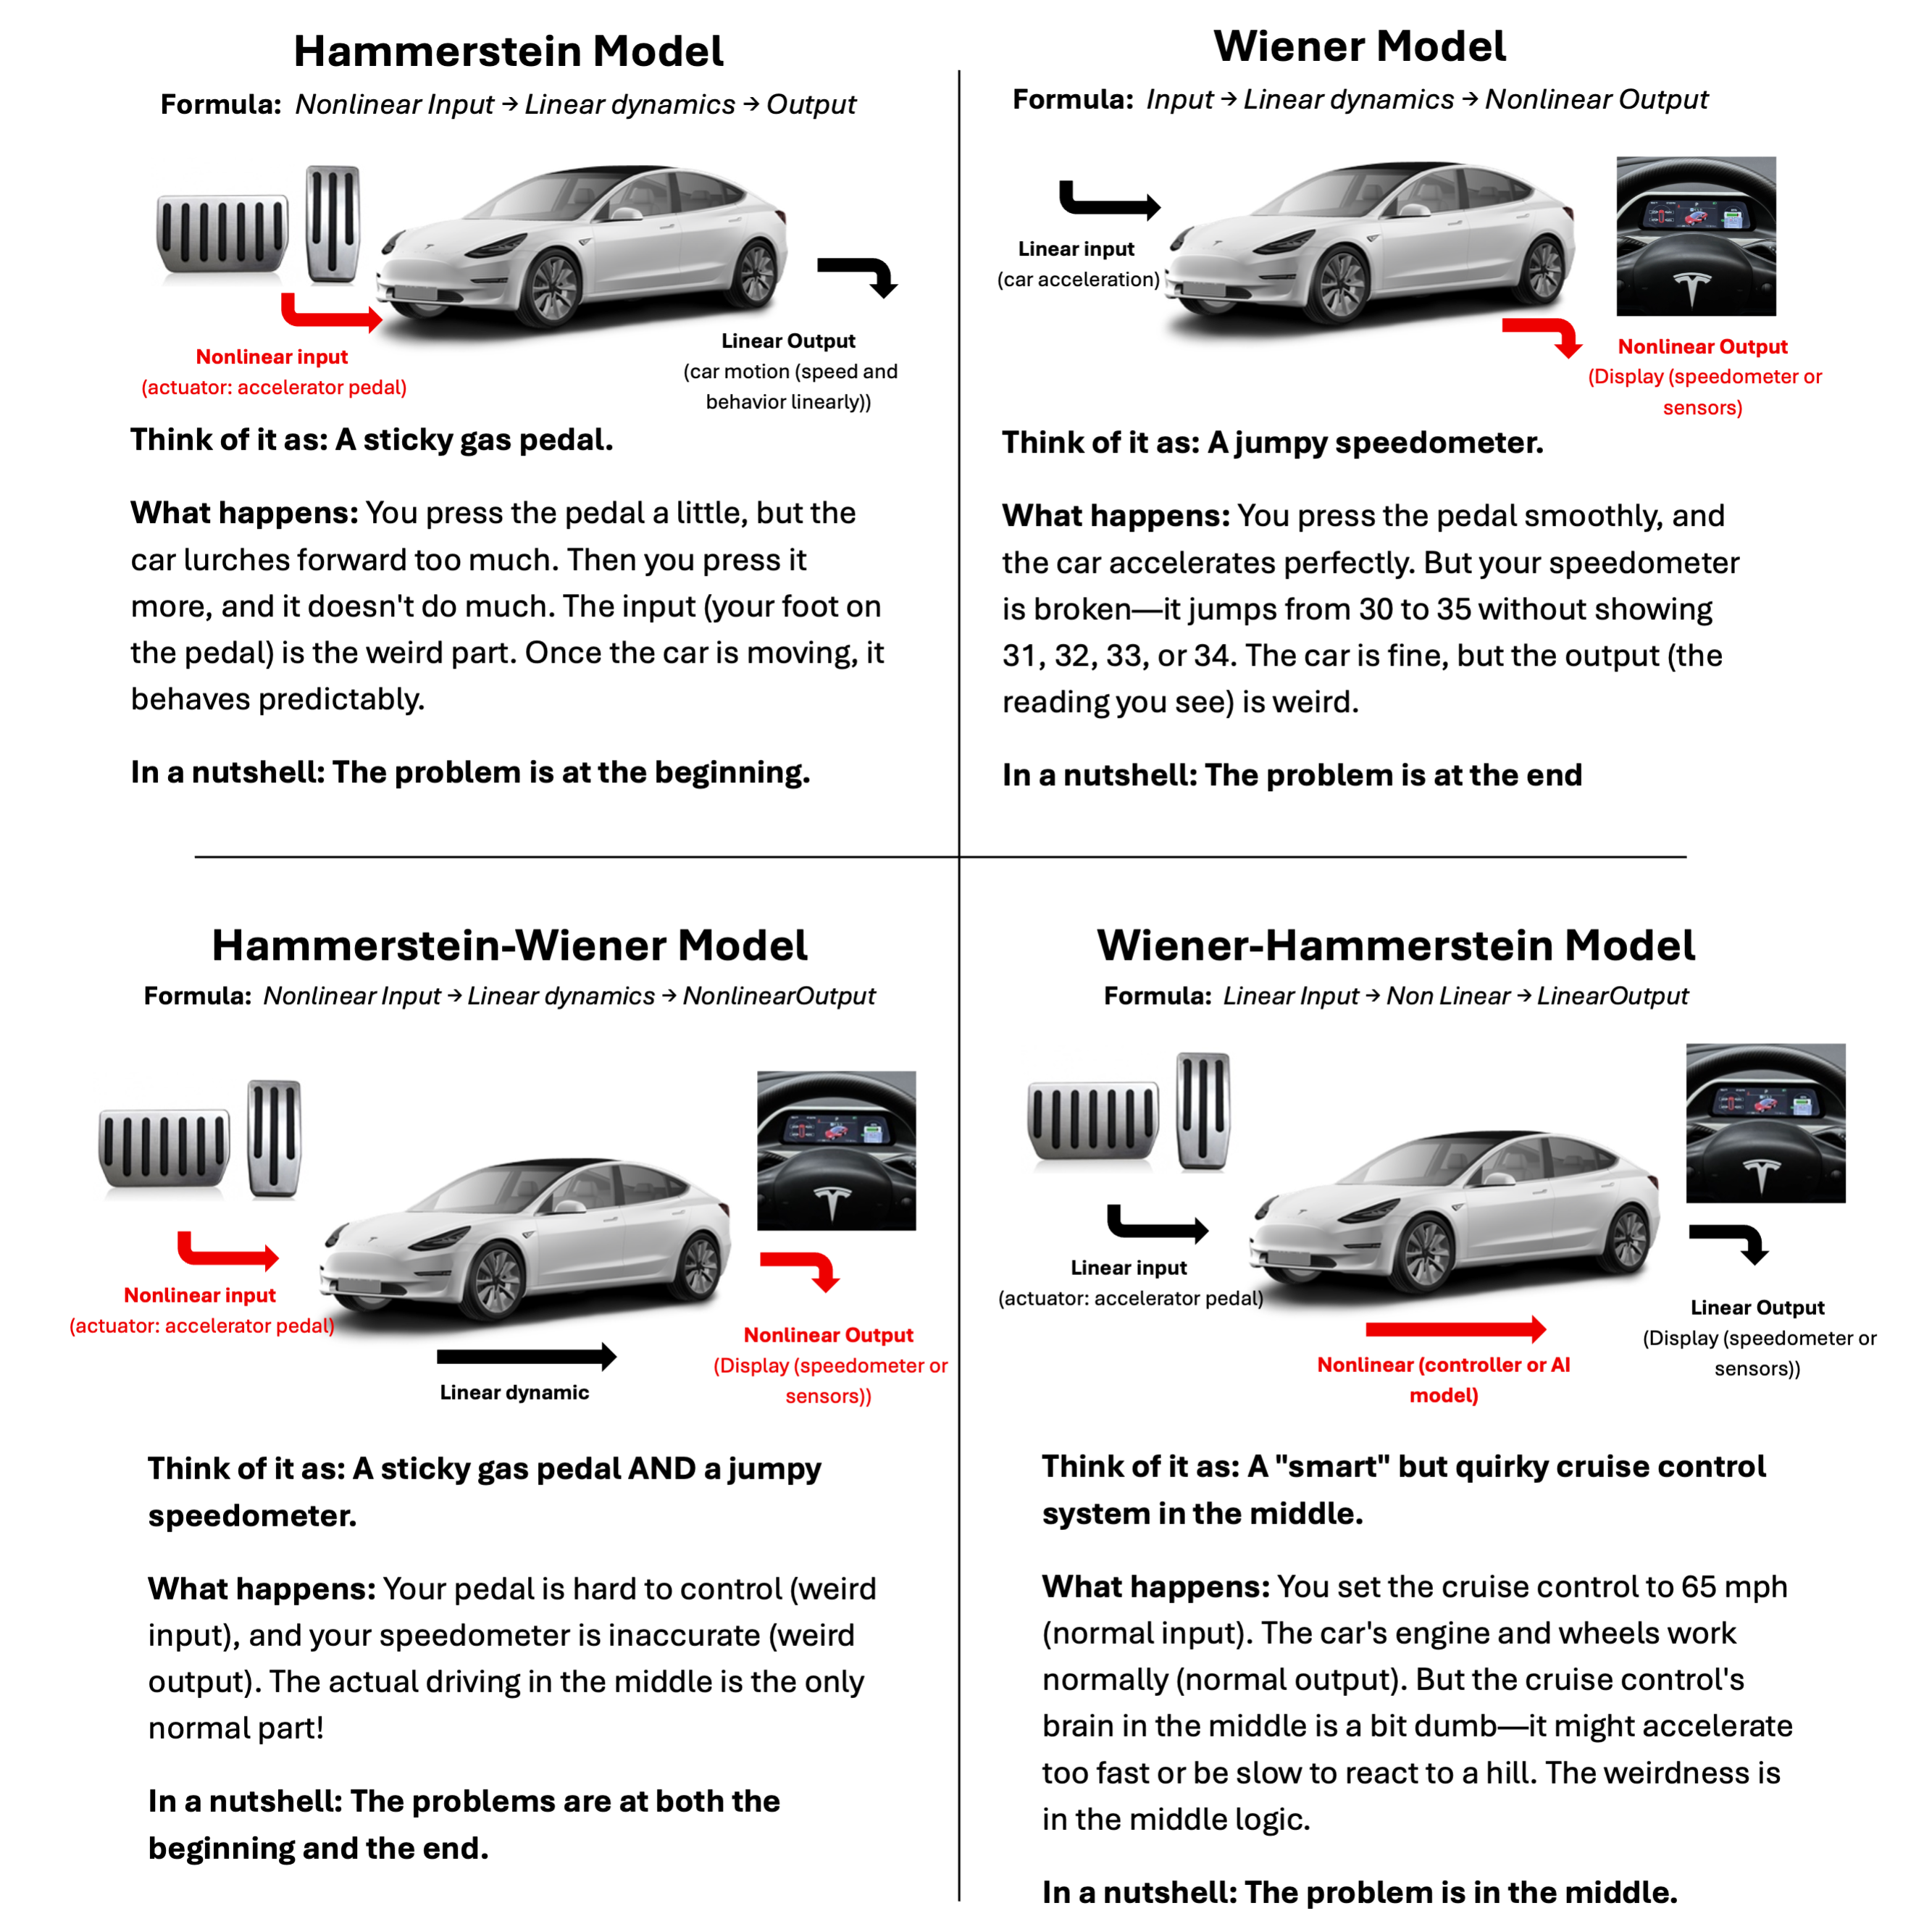

In [ ]:
from google.colab import files
from IPython.display import Image

# This will open a file picker window
uploaded = files.upload()

# Get the first uploaded file's name
uploaded_filename = next(iter(uploaded))

# Display the image
Image(uploaded_filename)

 **Current use:** Why this matters Tesla, Waymo, and others use these kinds of models to simulate and predict vehicle behavior, energy use, and sensor responses , especially when the data doesn’t behave perfectly linearly. So next time your car’s cruise control feels “too slow” or “too jumpy,” some engineer is probably trying to fix that using a Hammerstein–Wiener model

/tmp/ipython-input-811760535.py:153: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.legend(handles=[patches.Patch(color=facecolor_map.get('red', (0.7,0.7,0.7,0.2)), edgecolor='red', label='Input Nonlinearity'),
/tmp/ipython-input-811760535.py:154: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches.Patch(color=facecolor_map.get('green', (0.7,0.7,0.7,0.2)), edgecolor='green', label='Linear Dynamics'),
/tmp/ipython-input-811760535.py:155: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches.Patch(color=facecolor_map.get('purple', (0.7,0.7,0.7,0.2)), edgecolor='purple', label='Output Nonlinearity')],


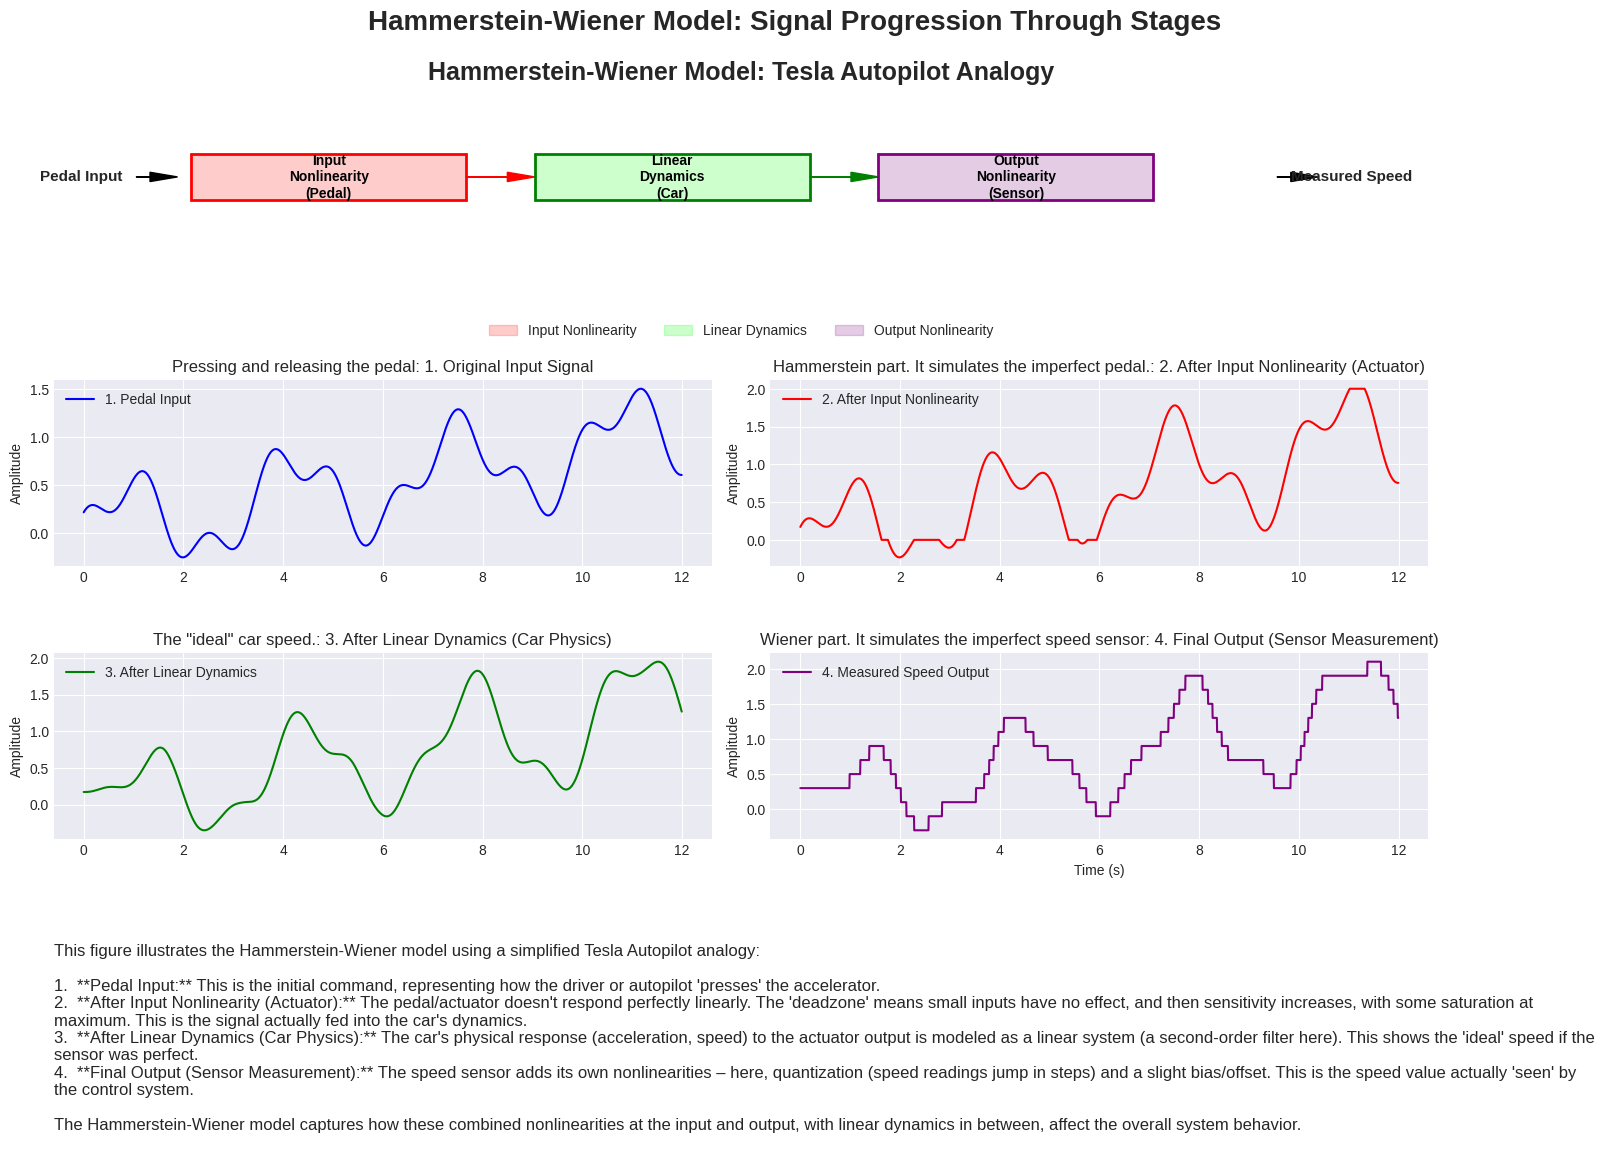

In [ ]:
# ===============================================================
# Hammerstein-Wiener Model Example Simulating a simplified "Tesla Autopilot" scenario
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.patches as patches

# Set up the plot style
plt.style.use('seaborn-v0_8-darkgrid') # Using a different style for variety
fig = plt.figure(figsize=(16, 12))

# Create a more flexible grid layout
gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 1])
ax_diagram = fig.add_subplot(gs[0, :]) # Full width for diagram
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])
ax_text = fig.add_subplot(gs[3, :]) # Full width for text explanation


# Time vector
fs = 200.0                # Sampling frequency (Hz)
T = 12.0                  # Total time (s)
t = np.arange(0, T, 1/fs)

# Input: Driver's pedal command (representing input signal)
# More dynamic input to show model response clearly
pedal_input = 1.0 * np.sin(2*np.pi*0.3*t) + 0.5 * np.cos(2*np.pi*0.8*t) + 0.2 * t
pedal_input = pedal_input / np.max(np.abs(pedal_input)) * 1.5 # Normalize and scale


# -------------------------------
# Define a Linear Dynamics Block (Simplified car dynamics)
# -------------------------------
# Second-order system representing vehicle response (acceleration/speed)
wn = 2.0 * np.pi * 0.6   # natural frequency (rad/s) - slightly slower response
zeta = 0.4               # damping ratio
num = [wn**2]
den = [1, 2*zeta*wn, wn**2]
sysc = signal.TransferFunction(num, den)
sysd = sysc.to_discrete(1/fs, method='bilinear')
b_lin, a_lin = sysd.num, sysd.den

def apply_lti(b, a, x):
    """Apply discrete LTI system defined by (b, a)."""
    # Add initial state argument to handle transients better
    zi = signal.lfilter_zi(b, a)
    y, _ = signal.lfilter(b, a, x, zi=zi*x[0])
    return y


# -------------------------------
# Define Static Nonlinearities
# -------------------------------
def input_nonlinearity_pedal(u):
    # Represents a pedal with a deadzone and then increasing sensitivity
    deadzone = 0.1
    y = np.copy(u)
    y[np.abs(y) < deadzone] = 0
    y[y >= deadzone] = 1.5 * (y[y >= deadzone] - deadzone) # Increased sensitivity
    y[y <= -deadzone] = 1.5 * (y[y <= -deadzone] + deadzone)
    # Add some saturation at higher values
    saturation_limit = 2.0
    y[y > saturation_limit] = saturation_limit
    y[y < -saturation_limit] = -saturation_limit
    return y

def output_nonlinearity_sensor(y):
    # Represents a sensor with quantization and a slight offset
    quantization_step = 0.2
    yq = np.round(y / quantization_step) * quantization_step
    offset = 0.1 # Small sensor bias
    return yq + offset


# ===============================================================
# Hammerstein–Wiener Model Stages (Simulating the flow)
# Pedal Input -> [Input Nonlinearity (Actuator)] -> [Linear Dynamics (Car)] -> [Output Nonlinearity (Sensor)] -> Measured Speed Output
# ===============================================================

# Stage 1: Apply Input Nonlinearity (Pedal/Actuator)
actuator_output = input_nonlinearity_pedal(pedal_input)

# Stage 2: Apply Linear Dynamics (Car's physical response)
car_speed_linear = apply_lti(b_lin, a_lin, actuator_output)

# Stage 3: Apply Output Nonlinearity (Speed Sensor)
measured_speed_output = output_nonlinearity_sensor(car_speed_linear)


# -------------------------------
# 1. SYSTEM DIAGRAM - Show the flow visually
# -------------------------------
def draw_system_diagram(ax, title, stages, colors):
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    ax.axis('off')
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)

    box_width = 2
    box_height = 1.5 # Increased box height again
    arrow_length = 0.5
    text_offset_y = box_height / 2 # Center text vertically within the new height
    arrow_head_width = 0.3
    arrow_head_length = 0.2

    # Improved text for boxes
    stage_text_map = {
        "Input\nNonlinearity\n(Pedal/Actuator)": "Input\nNonlinearity\n(Pedal)",
        "Linear\nDynamics\n(Car Physics)": "Linear\nDynamics\n(Car)",
        "Output\nNonlinearity\n(Sensor)": "Output\nNonlinearity\n(Sensor)"
    }


    for i, (stage, color) in enumerate(zip(stages, colors)):
        x = 1 + i * 2.5
        y = 3

        # Define facecolor with alpha
        facecolor_map = {
            'red': (1, 0, 0, 0.2),
            'green': (0, 1, 0, 0.2),
            'purple': (0.5, 0, 0.5, 0.2)
        }
        facecolor = facecolor_map.get(color, (0.7, 0.7, 0.7, 0.2)) # Default grey

        rect = patches.Rectangle((x, y), box_width, box_height, linewidth=2, # Use new box height
                                 edgecolor=color, facecolor=facecolor, label=stage)
        ax.add_patch(rect)
        # Use improved text and adjusted fontsize
        ax.text(x + box_width/2, y + text_offset_y, stage_text_map.get(stage, stage), ha='center', va='center', # Use new text offset
                fontweight='bold', fontsize=10, color='black') # Decreased fontsize slightly


        # Draw arrows
        if i < len(stages) - 1:
            ax.arrow(x + box_width, y + text_offset_y, arrow_length, 0,
                     head_width=arrow_head_width,
                     head_length=arrow_head_length, fc=color, ec=color, length_includes_head=True)

    # Add input and output labels
    ax.text(0.5, y + text_offset_y, 'Pedal Input', ha='right', va='center', fontsize=11, fontweight='bold')
    ax.arrow(0.6, y + text_offset_y, 0.3, 0, head_width=arrow_head_width,
             head_length=arrow_head_length, fc='black', ec='black', length_includes_head=True)

    ax.text(x + box_width + arrow_length + 0.5, y + text_offset_y, 'Measured Speed', ha='left', va='center', fontsize=11, fontweight='bold')
    ax.arrow(x + box_width + arrow_length + 0.4, y + text_offset_y, 0.3, 0, head_width=arrow_head_width,
             head_length=arrow_head_length, fc='black', ec='black', length_includes_head=True)

    ax.legend(handles=[patches.Patch(color=facecolor_map.get('red', (0.7,0.7,0.7,0.2)), edgecolor='red', label='Input Nonlinearity'),
                       patches.Patch(color=facecolor_map.get('green', (0.7,0.7,0.7,0.2)), edgecolor='green', label='Linear Dynamics'),
                       patches.Patch(color=facecolor_map.get('purple', (0.7,0.7,0.7,0.2)), edgecolor='purple', label='Output Nonlinearity')],
              loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=10)


draw_system_diagram(ax_diagram, "Hammerstein-Wiener Model: Tesla Autopilot Analogy",
                    ["Input\nNonlinearity\n(Pedal/Actuator)", "Linear\nDynamics\n(Car Physics)", "Output\nNonlinearity\n(Sensor)"],
                    ['red', 'green', 'purple'])


# -------------------------------
# 2. Plot Signals at Each Stage
# -------------------------------

# Plot 1: Original Input (Pedal Command)
ax1.plot(t, pedal_input, label='1. Pedal Input', color='blue')
ax1.set_ylabel('Amplitude')
ax1.set_title('Pressing and releasing the pedal: 1. Original Input Signal')
ax1.grid(True)
ax1.legend()

# Plot 2: After Input Nonlinearity (Actuator Output)
ax2.plot(t, actuator_output, label='2. After Input Nonlinearity', color='red')
ax2.set_ylabel('Amplitude')
ax2.set_title('Hammerstein part. It simulates the imperfect pedal.: 2. After Input Nonlinearity (Actuator)')
ax2.grid(True)
ax2.legend()

# Plot 3: After Linear Dynamics (Ideal Car Speed)
ax3.plot(t, car_speed_linear, label='3. After Linear Dynamics', color='green')
ax3.set_ylabel('Amplitude')
ax3.set_title('The "ideal" car speed.: 3. After Linear Dynamics (Car Physics)')
ax3.grid(True)
ax3.legend()

# Plot 4: Final Output (Measured Speed from Sensor)
ax4.plot(t, measured_speed_output, label='4. Measured Speed Output', color='purple')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Amplitude')
ax4.set_title('Wiener part. It simulates the imperfect speed sensor: 4. Final Output (Sensor Measurement)')
ax4.grid(True)
ax4.legend()

# -------------------------------
# 3. Text Explanation
# -------------------------------
ax_text.axis('off')
explanation_text = """
This figure illustrates the Hammerstein-Wiener model using a simplified Tesla Autopilot analogy:

1.  **Pedal Input:** This is the initial command, representing how the driver or autopilot 'presses' the accelerator.
2.  **After Input Nonlinearity (Actuator):** The pedal/actuator doesn't respond perfectly linearly. The 'deadzone' means small inputs have no effect, and then sensitivity increases, with some saturation at maximum. This is the signal actually fed into the car's dynamics.
3.  **After Linear Dynamics (Car Physics):** The car's physical response (acceleration, speed) to the actuator output is modeled as a linear system (a second-order filter here). This shows the 'ideal' speed if the sensor was perfect.
4.  **Final Output (Sensor Measurement):** The speed sensor adds its own nonlinearities – here, quantization (speed readings jump in steps) and a slight bias/offset. This is the speed value actually 'seen' by the control system.

The Hammerstein-Wiener model captures how these combined nonlinearities at the input and output, with linear dynamics in between, affect the overall system behavior.
"""
ax_text.text(0.0, 1.0, explanation_text, ha='left', va='top', fontsize=12, wrap=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.suptitle('Hammerstein-Wiener Model: Signal Progression Through Stages', fontsize=20, fontweight='bold')
plt.show()


## The identification problem

Our general Hammerstein–Wiener (NLHW) model:

$$
\hat{y}(t;\theta) = h\!\Big( G(q^{-1};\theta_G)\,[\,f(u(t);\theta_f)\,];\theta_h \Big)
$$

where  
- $\theta=\{\theta_f,\theta_G,\theta_h\}$ — all unknown parameters.

For the standard least-squares identification problem:
$$
\min_{\theta} \;J(\theta) = \sum_{t=1}^N \big(y(t)-\hat{y}(t;\theta)\big)^2
$$


---

## You can put this directly into an optimization algorithm, but:
- Hammerstein–Wiener identification is nonlinear and **nonconvex**.  
- Good initialization (e.g. linear identification first) helps avoid local minima.  
- Regularization or parameter constraints can improve robustness.


## System Identification Process

- **1. Data Collection**

- **2. Choose Model Structure**
  - input/output nonlinearities (e.g., polynomial, sigmoid, piecewise)
  - linear dynamic model (e.g., ARX, state-space, transfer function) and **order**

- **3. Estimate Linear Dynamics**

- **4. Identify Nonlinearities**
  - Fit static nonlinear functions to the residuals or transformed signals using regression techniques

- **5a). Model Fitting by Iterative Refinement**
  - Alternate between refining each components - keeping the other constant

- **5b). Model Fitting by Optimization**
  - Minimize overall prediction error using optimization methods

- **6. Validation**





## Some libraries
- Matlab: nlhw https://se.mathworks.com/help/ident/ref/nlhw.html
- Python: hwm https://hwm.readthedocs.io/en/latest/index.html



# Example

In [ ]:
!pip install hwm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 89.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4

/tmp/ipython-input-231105921.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_time_slice = df_time_slice.resample('5S').mean()


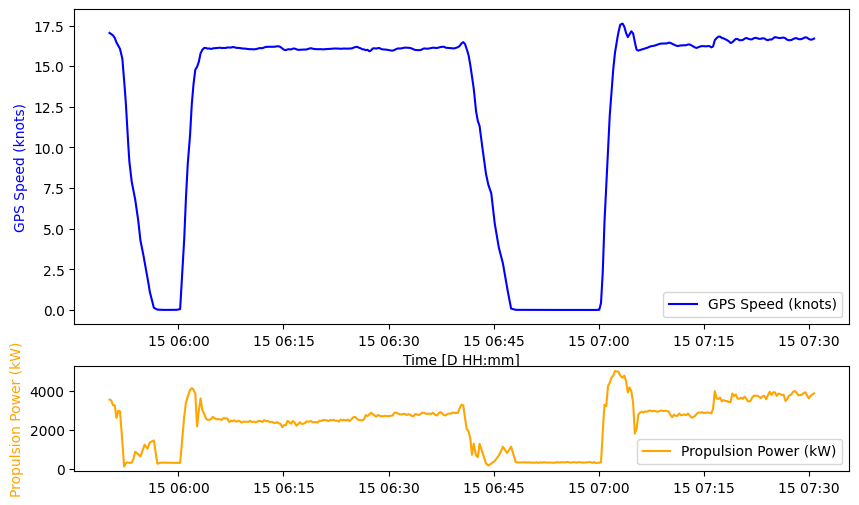

In [ ]:
import pandas as pd
df_time_slice = pd.read_parquet('/content/speed_power_time_slice.pqt')
df_time_slice = df_time_slice.resample('5S').mean()
df_time_slice = df_time_slice.interpolate(method='time')

import matplotlib.pyplot as plt

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 6), height_ratios=[3, 1])
ax1.plot(df_time_slice.index, df_time_slice['GPS_Speed'], label='GPS Speed (knots)', color='blue')
ax2.plot(df_time_slice.index, df_time_slice['Propulsion_Power'], label='Propulsion Power (kW)', color='orange')
# ax2.plot(df_time_slice.index, df_time_slice['Total_Power'], label='Total Power (kW)', color='green', alpha=0.5)
ax1.set_xlabel('Time [D HH:mm]')
ax1.set_ylabel('GPS Speed (knots)', color='blue')
ax2.set_ylabel('Propulsion Power (kW)', color='orange')
ax1.legend()
ax2.legend()

In [ ]:
y = df_time_slice['GPS_Speed'].to_numpy(dtype=float).reshape(-1, 1)  # ensures numeric
u = df_time_slice['Propulsion_Power'].to_numpy(dtype=float).reshape(-1, 1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_u = StandardScaler()
scaler_y = StandardScaler()

u_scaled = scaler_u.fit_transform(u)
y_scaled = scaler_y.fit_transform(y)

In [ ]:
from hwm.estimators import  HWRegressor, HammersteinWienerRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import numpy as np

input_nonlinearity = MLPRegressor(hidden_layer_sizes=(20, 10),
                                  activation='relu',
                                  max_iter=2000)
output_nonlinearity = LinearRegression()

model_Nonlinear = HWRegressor(
    nonlinear_input_estimator = input_nonlinearity,
    nonlinear_output_estimator = output_nonlinearity,
    p = 100,
    max_iter = 100
)
model_linear = HWRegressor(
    nonlinear_input_estimator = None,
    nonlinear_output_estimator = None,
    p = 100,
    max_iter = 100
)

In [ ]:
model_Nonlinear.fit(u_scaled, y_scaled)
model_linear.fit(u_scaled, y_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Starting training for 100 epochs.
Epoch 1/100
6/6 [==============================] - loss: 0.0444 - pss: 0.9653 - val_loss: 2.2635 - val_pss: 1.0438
Epoch 2/100
3/6 [===============>..............] - loss: 0.0444 - pss: 0.9653

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6/6 [==============================] - loss: 0.0433 - pss: 0.9651 - val_loss: 2.2632 - val_pss: 1.0428
Epoch 3/100
6/6 [==============================] - loss: 0.0429 - pss: 0.9660 - val_loss: 2.2635 - val_pss: 1.0433
Epoch 4/100
6/6 [==============================] - loss: 0.0427 - pss: 0.9670 - val_loss: 2.2639 - val_pss: 1.0438
Epoch 5/100
6/6 [==============================] - loss: 0.0426 - pss: 0.9680 - val_loss: 2.2642 - val_pss: 1.0442
Epoch 6/100
6/6 [==============================] - loss: 0.0425 - pss: 0.9688 - val_loss: 2.2642 - val_pss: 1.0445
Epoch 7/100
6/6 [==============================] - loss: 0.0424 - pss: 0.9695 - val_loss: 2.2641 - val_pss: 1.0446
Epoch 8/100
6/6 [==============================] - loss: 0.0424 - pss: 0.9701 - val_loss: 2.2639 - val_pss: 1.0447
Epoch 9/100
6/6 [==============================] - loss: 0.0423 - pss: 0.9706 - val_loss: 2.2636 - val_pss: 1.0447
Epoch 10/100
6/6 [==============================] - loss: 0.0423 - pss: 0.9711 - val_loss: 2

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6/6 [==============================] - loss: 0.1088 - pss: 1.1309 - val_loss: 2.1718 - val_pss: 1.1809
Epoch 4/100
6/6 [==============================] - loss: 0.1086 - pss: 1.1308 - val_loss: 2.1718 - val_pss: 1.1813
Epoch 5/100
6/6 [==============================] - loss: 0.1085 - pss: 1.1305 - val_loss: 2.1719 - val_pss: 1.1815
Epoch 6/100
6/6 [==============================] - loss: 0.1083 - pss: 1.1303 - val_loss: 2.1719 - val_pss: 1.1816
Epoch 7/100
6/6 [==============================] - loss: 0.1082 - pss: 1.1301 - val_loss: 2.1718 - val_pss: 1.1817
Epoch 8/100
6/6 [==============================] - loss: 0.1081 - pss: 1.1299 - val_loss: 2.1717 - val_pss: 1.1817
Epoch 9/100
6/6 [==============================] - loss: 0.1080 - pss: 1.1297 - val_loss: 2.1716 - val_pss: 1.1817
Epoch 10/100
6/6 [==============================] - loss: 0.1079 - pss: 1.1295 - val_loss: 2.1715 - val_pss: 1.1817
Epoch 11/100
6/6 [==============================] - loss: 0.1078 - pss: 1.1293 - val_loss: 

HWRegressor(p=100)

 3/3 [==============================] 100.0%   - ETA: 0.02s


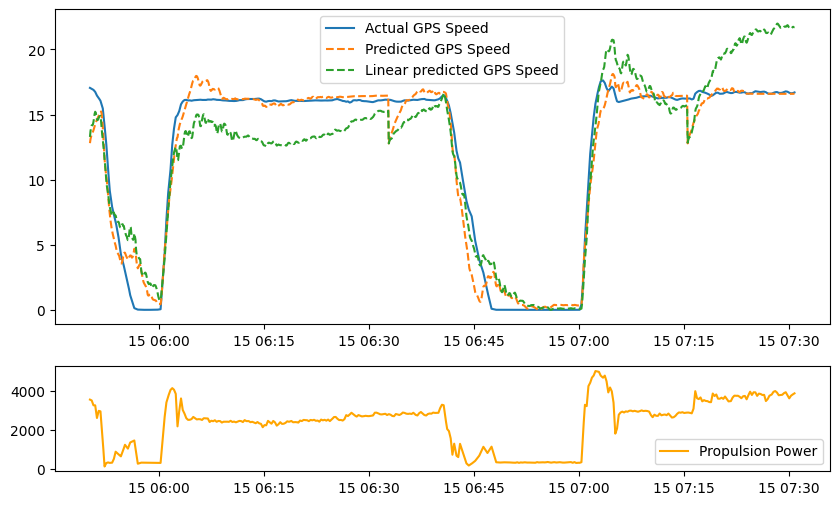

In [ ]:
# @title
y_pred = model_Nonlinear.predict(u_scaled)
y_linear = model_linear.predict(u_scaled)
y_pred = scaler_y.inverse_transform(y_pred)
y_linear = scaler_y.inverse_transform(y_linear)
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 6), height_ratios=[3, 1])
ax1.plot(df_time_slice.index, y.flatten(), label='Actual GPS Speed')
ax1.plot(df_time_slice.index, y_pred.flatten(), '--', label='Predicted GPS Speed')
ax1.plot(df_time_slice.index, y_linear.flatten(), '--', label='Linear predicted GPS Speed')
ax2.plot(df_time_slice.index, u.flatten(), color='orange', label='Propulsion Power')
# plt.title('Actual vs Predicted GPS Speed over Time')
# plt.xlabel('Time')
# plt.ylabel('Speed')
ax1.legend()
ax2.legend()